<a href="https://colab.research.google.com/github/GraceHerchenroder/Neuro265/blob/main/notebooks/PSD_03_20_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extracting Different Frequencies from Continuously Sampled Data

In this notebook (and our next few notebooks), you will learn the basics of working with continuously sampled data - specifically, EEG (electroencephalogram) and LFP (local field potential) data.

##By the end of this notebook, you will be able to:
- Calculate the Fourier transform on LFP data
- Graph a power spectrum from the Fourier transform
- Calculate the amplitude of defined frequency bands

Brainwaves are complex! Contained within them are signals that have various frequencies, as illustrated below:


<img src = 'https://drive.google.com/uc?id=1aZEruoM7r886Te6fvs7SFMAhuv_ev74s'>

Different frequency bands represent different neural processes - for example, interactions between interneurons and pyramidal neurons contribute heavily to higher-frequency oscillations (like **gamma** oscillations), while slow fluctuations in pyramidal neuron activity are linked to lower-frequency oscilltions (like **delta** oscillations).

These different oscillations have also been linked to different cognitive processes, highlighting the importance of studying them in the context of behavior

In this notebook, we will de-construct the LFP (local field potential) from a mouse behavioral experiment. The LFP data for this experiment were recorded from an area of the brain called the anterior cingulate cortex (or ACC for short).

In [1]:
# Let's start by importing relevant modules

import numpy as np
import matplotlib.pyplot as plt

For this study, we trained mice to pay attention to a stimulus on a screen (the S+). When this stimulus appeared, mice were shaped to respond to it by poking the screen with their nose. When they responded successfully, they were rewarded with some strawberry milk.

<img src = 'https://drive.google.com/uc?id=1wUDSndpJy1J1YaD7u_tHYaZNNhpdBfl8'>

To make it harder for the mice to pay attention to the S+, we also showed mice another stimulus - the S-. This stimulus looked different from the S+. When mice responded to the S- (they did this often when they were still learning how to do the task), they did not receive a reward.

When mice make a correct response (responding to the S+), we call that a **hit**. When mice make an incorrect response (responding to the S-), we call that a **false alarm**.

The following data are LFP signals from the ACC during **hits** (times when the mouse made a correct response). The data are in the same format as the data from last class: Rows correspond to trials, and columns correspond to samples. The sampling rate for these data is 2000 Hz.

In [3]:
# Load the data in as a numpy array

url = 'https://raw.githubusercontent.com/hallockh/neur_265/main/data/acc_test.csv'

acc_test = np.loadtxt(url, delimiter = ',')

><b>Task:</b> Take a look at the shape of your data. How many trials are recorded? In the code cell below, write an expression that will return the length of the data, in seconds. Then, create a <code>time</code> variable that is equal in length to your <code>acc_test</code> variable, starts with a value of "0", ends with a value equal to the length of time in seconds that you found, with equally spaced numbers in between. You can accomplish this with the <code>np.linspace</code> method.

In [8]:
# Your code here
[trials, samples] = acc_test.shape

print(acc_test.shape)

frequency = 2000
time_end = samples/frequency

time = np.linspace(0, time_end, samples)

(10, 8001)


### Trials, Samples, Time
There were 10 trials with 8001 samples taken in each trial. As the sampling rate is 2000 Hz, the trial took approximately 4 seconds to complete as this would be the number of samples divided by the frequency.

><b>Task:</b> Plot the first trial from your <code>acc_test</code> variable, with time in seconds on the x-axis. Label your axes, and give your plot a title!

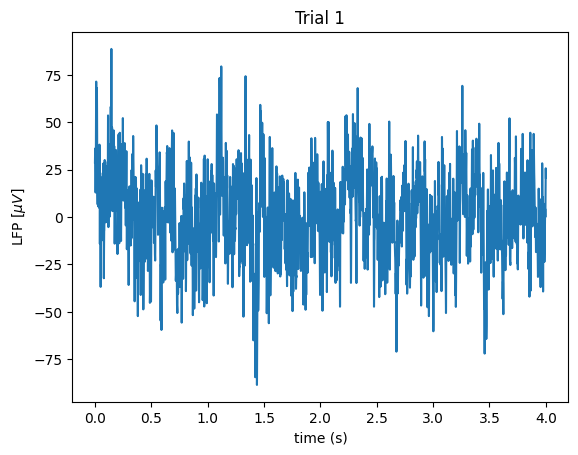

In [14]:
# Your code here!
plt.plot(time, acc_test[1])
plt.xlabel('time (s)')
plt.ylabel('LFP [$\mu V$]')
plt.title('Trial 1')

plt.show()

One thing to piont out is that, even though it seems like the LFP trace is plotted as a continuous line, that’s incorrect. If we look more closely, we find that the data consists of discrete points.

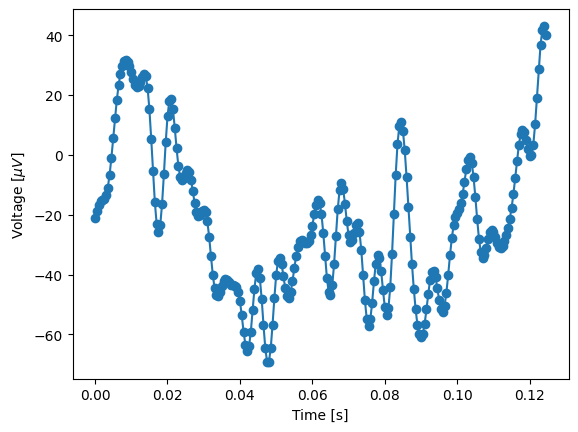

In [15]:
plt.plot(time[:250], acc_test[0,:250], 'o-')    # Plot the first 250 points (1/8 of a second) of data,
plt.xlabel('Time [s]')              # ... with axes labeled.
plt.ylabel('Voltage [$\mu V$]')

plt.show()

Although the true brain signal may evolve as a continuous voltage trace in time, we do not observe this true signal. Instead, we observe a discrete sampling of this signal in time. The spacing between these samples is determined by the recording device collecting the LFP (or EEG) data. In this case, we know that the data were sampled at 2000 Hz, which corresponds to a sample of data every 0.5 ms. So, we observe not the (presumably) continuous true voltage signal, but instead discrete samples of this signal in time.

To understand the impact of this discrete sampling, we first require some definitions. Let’s define Δ
 as the time between samples, in this case, Δ=0.5
 ms. We also define 𝑁
 as the total number of points observed, and 𝑇
 as the total time of the recording. These three terms are related:

𝑇=𝑁Δ
.

For the 𝑇=4
 s of LFP data, there are 𝑁=𝑇/𝑑𝑡=4/0.0005=8000
 points. From this, we can also define the sampling frequency

𝑓0=1/Δ

which in this case is 2000 Hz. Finally, we define a symbol for the data, 𝑥
, which we also write as 𝑥𝑛
 to explicitly indicate the index 𝑛∈{1,2,3,…,𝑁}
 corresponding to the sample number. Let’s also define all of these variables in Python:

In [20]:
x = acc_test[0,:-2]           # Relabel the data variable
dt = time[1] - time[0]  # Define the sampling interval
N = x.shape[0]    # Define the total number of data points
T = N * dt

We will need to keep the sampling interval Δ
 and the total recording duration 𝑇
 in mind—both will serve fundamental roles in our characterization of the rhythmic activity.

There are many techniques to assess rhythmic activity in the EEG data. Here, we compute the power spectral density, or simply the spectrum, of `𝑥`
 using a well-established technique, the [Fourier transform]('https://en.wikipedia.org/wiki/Fourier_transform'). There are many subtleties associated with computing and interpreting the spectrum. We explore some of them here; in doing so, we build our intuition for spectral analysis and our ability to deal with future, unforeseen circumstances in other data we encounter in research.

We start by presenting all the code necessary to compute the spectrum of the data. Then throughout the rest of this notebook, we circle back and consider each step of the computation in detail.

Computing the spectrum in Python requires only a few lines of code:

Text(0, 0.5, 'Power [$\\mu V^2$/Hz]')

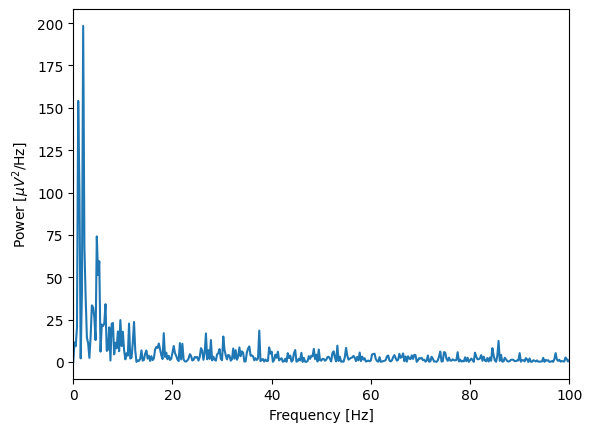

In [21]:
xf = np.fft.fft(x - x.mean())                  # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * np.conj(xf)) # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]             # Ignore negative frequencies

df = 1 / T.max()                        # Determine frequency resolution
fNQ = 1 / dt / 2                        # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)                # Construct frequency axis

plt.plot(faxis[:-1], np.real(Sxx))                  # Plot spectrum vs frequency
plt.xlim([0, 100])                          # Select frequency range
plt.xlabel('Frequency [Hz]')                # Label the axes
plt.ylabel('Power [$\mu V^2$/Hz]')


## Dominant Oscillation

The dominant oscillation would be approximately 2 Hz as it has the greatest power

><b>Task:</b> Re-work the above code to calculate and plot the power spectral density from the second, third, fourth, and fifth trials of <code>acc_hits</code>. How does the power spectrum differ from trial to trial? What is the dominant oscillation within the ACC LFP?

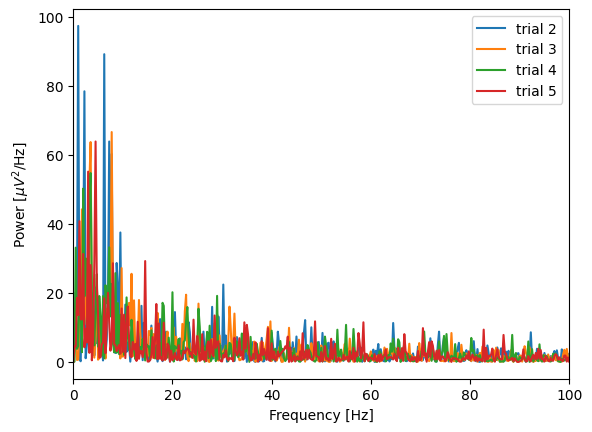

In [27]:
# Plotting the power for the second through fifth trials
for i in range(1, 5):
  x = acc_test[i,:-2]           # Relabel the data variable
  dt = time[1] - time[0]  # Define the sampling interval
  N = x.shape[0]    # Define the total number of data points
  T = N * dt

  xf = np.fft.fft(x - x.mean())                  # Compute Fourier transform of x
  Sxx = 2 * dt ** 2 / T * (xf * np.conj(xf)) # Compute spectrum
  Sxx = Sxx[:int(len(x) / 2)]             # Ignore negative frequencies

  df = 1 / T.max()                        # Determine frequency resolution
  fNQ = 1 / dt / 2                        # Determine Nyquist frequency
  faxis = np.arange(0,fNQ,df)                # Construct frequency axis

  plt.plot(faxis[:-1], np.real(Sxx))                  # Plot spectrum vs frequency
  plt.xlim([0, 100])                          # Select frequency range
  plt.xlabel('Frequency [Hz]')                # Label the axes
  plt.ylabel('Power [$\mu V^2$/Hz]')

plt.legend(['trial 2', 'trial 3', 'trial 4', 'trial 5'])
plt.show()

Text(0, 0.5, 'Power [$\\mu V^2$/Hz]')

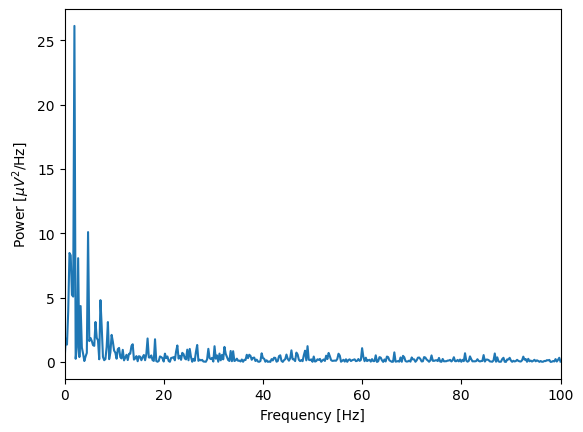

In [32]:
# Plotting the average power for all trials

acc_test_mean = acc_test.mean(0);

x = acc_test_mean[:-2]           # Relabel the data variable
dt = time[1] - time[0]  # Define the sampling interval
N = x.shape[0]    # Define the total number of data points
T = N * dt

xf = np.fft.fft(x - x.mean())                  # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * np.conj(xf)) # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]             # Ignore negative frequencies

df = 1 / T.max()                        # Determine frequency resolution
fNQ = 1 / dt / 2                        # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)                # Construct frequency axis

plt.plot(faxis[:-1], np.real(Sxx))                  # Plot spectrum vs frequency
plt.xlim([0, 100])                          # Select frequency range
plt.xlabel('Frequency [Hz]')                # Label the axes
plt.ylabel('Power [$\mu V^2$/Hz]')

##The Nyquist Frequency

The formula for the Nyquist frequency is

𝑓𝑁𝑄=𝑓0/2.

The Nyquist frequency is the highest frequency we can possibly hope to observe in the data. To illustrate this, let’s consider a true EEG signal that consists of a very simple time series—a pure sinusoid that oscillates at some frequency 𝑓𝑠
. Of course, we never observe the true signal. Instead, we observe a sampling of this signal, which depends on the sampling interval Δ
. We consider three cases for different values of Δ
. In the first case, we purchase a very expensive piece of equipment that can sample the true signal at a high rate, 𝑓0≫𝑓𝑠
. In this case, we cover the true brain signal with many samples and given these samples, we can accurately reconstruct the underlying data.

<img src = 'https://drive.google.com/uc?id=1ECLdXmPt_QZK9Rb9RlUjwOt40COZU7Wg'>

Now, consider the case in which we purchase a cheaper piece of equipment that samples at a maximum rate equivalent to twice the frequency of the pure sinusoid: 𝑓0=2𝑓𝑠
. In this case, we might collect sufficient samples to cover the underlying signal and approximate the oscillation frequency; if the first sample resides on a peak of the sinusoid, the next sample on a trough, and so on.



<img src = 'https://drive.google.com/uc?id=1fclkpCD9WhqM7hg4htuXSglMl6LBj0ON'>

In this case, we collect two samples per cycle of the underlying true signal. Given only these sample points, we can connect the dots and still approximate the frequency fo the true underlying sinusoid.

Question: For the sampling rate 𝑓0=2𝑓𝑠
, consider the case in which the first sample occurs on a zero crossing of the sinusoid. At what point does the next sample occur? and the next sample? If you connect the dots in this case, what do you find?

Finally, consider the case where our equipment records at a sampling rate less than the frequency of the pure sinusoid signal: 𝑓0<2𝑓𝑠
.

<img src = 'https://drive.google.com/uc?id=12re4EXM5Q2qDKiLnQtON1kluwSnHCn6Q'>

Assuming the first sample occurs at a peak of the sinusoid, the next sample occurs not at a trough (that would correspond to a sampling rate 𝑓0=2𝑓𝑠
) but instead just after the trough. Connecting the samples with lines, in this case, produces something horrifying, an oscillation occurring at a different, lower frequency. Notice what has happened in this case. Sampling the sinusoid at too low a frequency (i.e., at a frequency less than twice the signal’s frequency 𝑓0<2𝑓𝑠
) causes this signal to manifest at a low-frequency upon sampling. This phenomenon—a high-frequency signal appearing as a low-frequency signal upon sampling—is known as aliasing. Once a signal has been aliased, it’s impossible to distinguish from true signals oscillating at low frequencies.

##Decibel Scaling

** Note: at lower frequencies there tend to be higher amplitudes

The decibel is a logarithmic scale and easily computed as follows:

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Power [dB]')

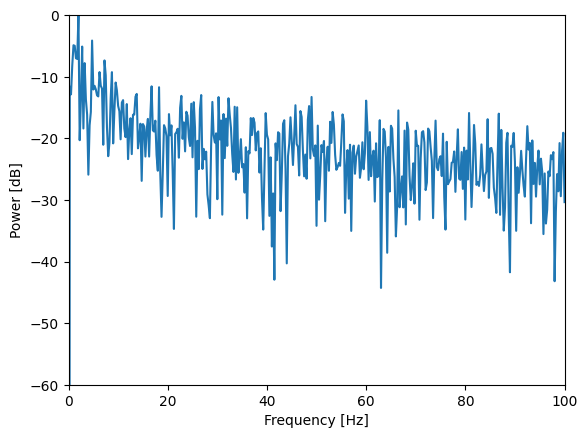

In [33]:
plt.plot(faxis[:-1], 10 * np.log10(Sxx / max(Sxx)))  # Plot the spectrum in decibels.
plt.xlim([0, 100])                           # Select the frequency range.
plt.ylim([-60, 0])                           # Select the decibel range.
plt.xlabel('Frequency [Hz]')                 # Label the axes.
plt.ylabel('Power [dB]')


To change to the decibel scale, we first divide the spectrum by the maximum value observed and then take the logarithm base 10 of this ratio and multiply the result by 10. The ~4 Hz rhythm is still dominant and exhibits the most power.

##The Spectrogram

The spectrum plotted using the decibel scale suggests that multiple rhythms appear in our LFP signal. Given only these results, we may reasonably conclude that these rhythms appear simultaneously throughout the entire 4 s of the LFP recording. That is an assumption we make in computing the spectrum of the entire 4 s interval. To further test this assumption in the LFP data, we compute a final quantity: the spectrogram. The idea of the spectrogram is to break up the time series into smaller intervals of data and then compute the spectrum in each interval. These intervals can be quite small and can even overlap. The result is the spectrum as a function of frequency and time.

To compute and display the spectrogram in Python, we use the (aptly named) function `spectrogram` from the `scipy` module:

Text(0, 0.5, 'Frequency [Hz]')

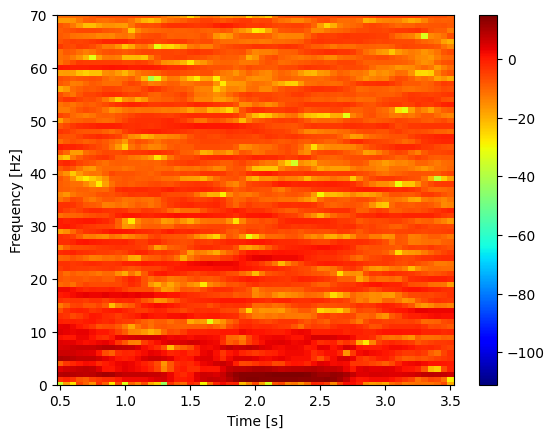

In [34]:
from scipy.signal import spectrogram

Fs = 1 / dt               # Define the sampling frequency,
interval = int(Fs)        # ... the interval size,
overlap = int(Fs * 0.95)  # ... and the overlap intervals

                          # Compute the spectrogram
f, t, Sxx = spectrogram(
    x,                  # Provide the signal,
    fs=Fs,                # ... the sampling frequency,
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)     # ... the number of samples to overlap,
plt.pcolormesh(t, f, 10 * np.log10(Sxx),
               cmap='jet')# Plot the result
plt.colorbar()                # ... with a color bar,
plt.ylim([0, 70])             # ... set the frequency range,
plt.xlabel('Time [s]')        # ... and label the axes
plt.ylabel('Frequency [Hz]')


><b>Task:</b> We've looked at the ACC in mice, and found dominant oscillations within the cortical LFP. What about other brain regions? Might they have different patterns of oscillations? To check this, let's look at another area of the brain - the hippocampus. We'll look at the LFP signal from the dorsal hippocampus of a rat as it runs down a maze. To do this, upload the <code>rat_dhc.csv</code> file from our class GitHub repo as a <code>numpy</code> array. You should see that this array has only one row - this row corresponds to a single trial of the task the rat was doing in the maze. Each column corresponds to a sample. The sampling rate for these data is 2034 Hz. Calculate the power spectrum and a spectrogram for this sample. Are there any differences in the power spectrum between the hippocampus and cortex?

Text(0, 0.5, 'Power [$\\mu V^2$/Hz]')

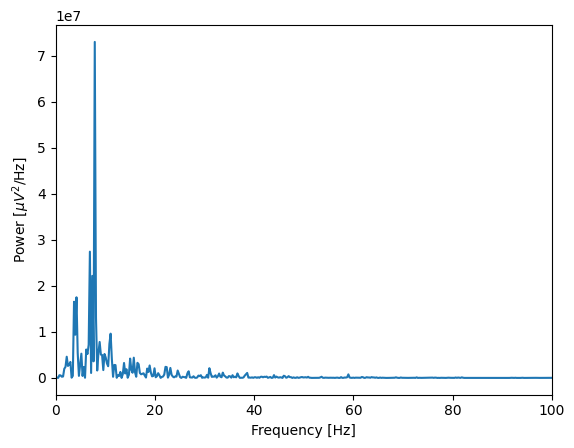

In [42]:
# Uploading data for hippocampus data
url_dhc = 'https://raw.githubusercontent.com/hallockh/neur_265/main/data/rat_dhc.csv'
acc_dhc = np.loadtxt(url_dhc, delimiter = ',')
samples_dhc = acc_dhc.size

# Creating time variable
frequency_dhc = 2034 #Hz
time_end_dhc = samples_dhc/frequency_dhc

time_dhc = np.linspace(0, time_end_dhc, samples_dhc)

# Power analysis
x = acc_dhc[:-2]           # Relabel the data variable
dt = time[1] - time[0]  # Define the sampling interval
N = x.shape[0]    # Define the total number of data points
T = N * dt

xf = np.fft.fft(x - x.mean())                  # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * np.conj(xf)) # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]             # Ignore negative frequencies

df = 1 / T.max()                        # Determine frequency resolution
fNQ = 1 / dt / 2                        # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)                # Construct frequency axis

plt.plot(faxis[:-1], np.real(Sxx))                  # Plot spectrum vs frequency
plt.xlim([0, 100])                          # Select frequency range
plt.xlabel('Frequency [Hz]')                # Label the axes
plt.ylabel('Power [$\mu V^2$/Hz]')

Text(0, 0.5, 'Frequency [Hz]')

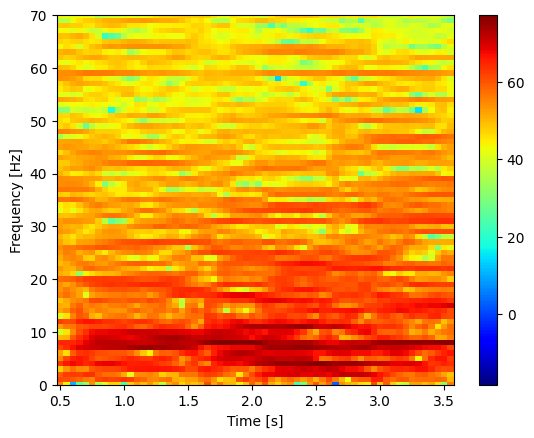

In [43]:
# Fourier Transform
Fs = 1 / dt               # Define the sampling frequency,
interval = int(Fs)        # ... the interval size,
overlap = int(Fs * 0.95)  # ... and the overlap intervals

                          # Compute the spectrogram
f, t, Sxx = spectrogram(
    x,                  # Provide the signal,
    fs=Fs,                # ... the sampling frequency,
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)     # ... the number of samples to overlap,
plt.pcolormesh(t, f, 10 * np.log10(Sxx),
               cmap='jet')# Plot the result
plt.colorbar()                # ... with a color bar,
plt.ylim([0, 70])             # ... set the frequency range,
plt.xlabel('Time [s]')        # ... and label the axes
plt.ylabel('Frequency [Hz]')